Using ARIMA model to predict the stock index price

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt         #for visualization
import seaborn as sns    #for visualization


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMA
from pandas_datareader.data import DataReader


/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

#Dow Jones U.S. Financial Services Index (USD)
#Dow Jones U.S. Health Care Index      

dataset = pd.read_excel("/Users/liuxichen/Downloads/3_index.xlsx")

    

In [3]:
dataset.head()

,Dates,PX_OPEN,LAST_PRICE,PX_OPEN.1,LAST_PRICE.1,PX_OPEN.2,LAST_PRICE.2
0,NaT,1161.02,1148.08,NaN,590.99,NaN,310.76
1,2002-01-02,1148.08,1154.67,590.99,590.99,310.85,309.24
2,2002-01-03,1154.67,1165.27,596.11,596.11,309.23,306.32
3,2002-01-04,1165.27,1172.51,610.01,610.01,306.32,306.00
4,2002-01-07,1172.51,1164.89,603.31,603.31,306.01,304.20


In [4]:
dataset.tail()

,Dates,PX_OPEN,LAST_PRICE,PX_OPEN.1,LAST_PRICE.1,PX_OPEN.2,LAST_PRICE.2
2084,2009-12-28,1127.53,1127.78,406.55,405.48,323.75,325.00
2085,2009-12-29,1128.55,1126.20,405.48,405.58,325.00,324.47
2086,2009-12-30,1125.53,1126.42,405.58,406.94,324.47,324.15
2087,2009-12-31,1126.60,1115.10,406.93,405.50,324.15,320.51
2088,2010-01-01,1126.60,1115.10,406.93,405.50,324.15,320.51


In [5]:
# drop the unnecessary columns(first two columns drop)
dataset.drop(['PX_OPEN','LAST_PRICE','PX_OPEN.1','PX_OPEN.2'],inplace=True, axis=1)

In [6]:
dataset.head()

,Dates,LAST_PRICE.1,LAST_PRICE.2
0,NaT,590.99,310.76
1,2002-01-02,590.99,309.24
2,2002-01-03,596.11,306.32
3,2002-01-04,610.01,306.00
4,2002-01-07,603.31,304.20


In [7]:
#Dow Jones U.S. Financial Services Sector Index(DJUSGF)
#Dow Jones U.S. Health Care Index(DJUSHC)

dataset.rename(columns={"LAST_PRICE.1":'DJUSGF',
               'LAST_PRICE.2':'DJUSHC'},inplace=True)

In [8]:
dataset.drop(index=[0])

,Dates,DJUSGF,DJUSHC
1,2002-01-02,590.99,309.24
2,2002-01-03,596.11,306.32
3,2002-01-04,610.01,306.00
4,2002-01-07,603.31,304.20
5,2002-01-08,591.00,303.79
...,...,...,...
2084,2009-12-28,405.48,325.00
2085,2009-12-29,405.58,324.47
2086,2009-12-30,406.94,324.15
2087,2009-12-31,405.50,320.51


In [9]:
dataset.describe()

,DJUSGF,DJUSHC
count,2089.000000,2089.000000
mean,590.273887,296.872647
std,166.383904,33.644827
min,194.450000,204.710000
25%,475.920000,271.160000
50%,600.420000,298.640000
75%,708.500000,320.510000
max,924.100000,367.730000


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   2088 non-null   datetime64[ns]
 1   DJUSGF  2089 non-null   float64       
 2   DJUSHC  2089 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 49.1 KB


In [11]:
dataset.set_index("Dates",inplace=True)


In [12]:
FinancialService_data_train=dataset.loc["2002-08-01":"2007-01-01","DJUSGF"]
HealthCare_data_train=dataset.loc["2002-08-01":"2007-01-01",'DJUSHC']

In [13]:
FinancialService_data_train.head()


Dates
2002-08-01    445.83
2002-08-02    429.41
2002-08-05    409.83
2002-08-06    423.02
2002-08-07    429.44
Name: DJUSGF, dtype: float64

In [14]:
FinancialService_data_train.tail()


Dates
2006-12-26    867.88
2006-12-27    876.10
2006-12-28    873.56
2006-12-29    867.77
2007-01-01    867.77
Name: DJUSGF, dtype: float64

In [15]:
HealthCare_data_train.head()


Dates
2002-08-01    239.85
2002-08-02    238.47
2002-08-05    228.73
2002-08-06    233.54
2002-08-07    241.24
Name: DJUSHC, dtype: float64

In [16]:
HealthCare_data_train.tail()

Dates
2006-12-26    331.76
2006-12-27    333.35
2006-12-28    333.47
2006-12-29    332.38
2007-01-01    332.38
Name: DJUSHC, dtype: float64

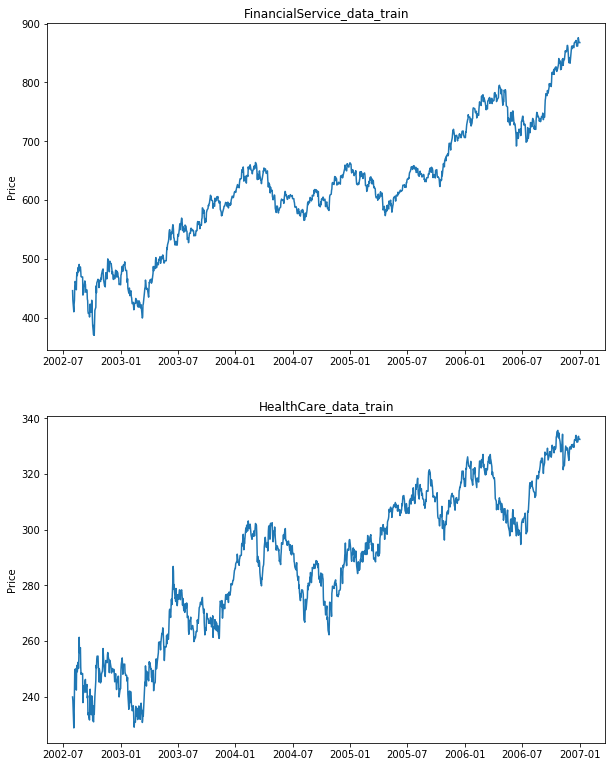

In [17]:
sectors=[FinancialService_data_train,HealthCare_data_train]
sectors_name=['FinancialService_data_train','HealthCare_data_train']
plt.figure(figsize=(10,200))
plt.subplots_adjust(top=1.25,bottom=1.2)

for i, sector in enumerate(sectors,1):
    plt.subplot(2,1,i)
    plt.plot(sector)
    plt.ylabel('Price')
    plt.title(f"{sectors_name[i - 1]}")
plt.show()    

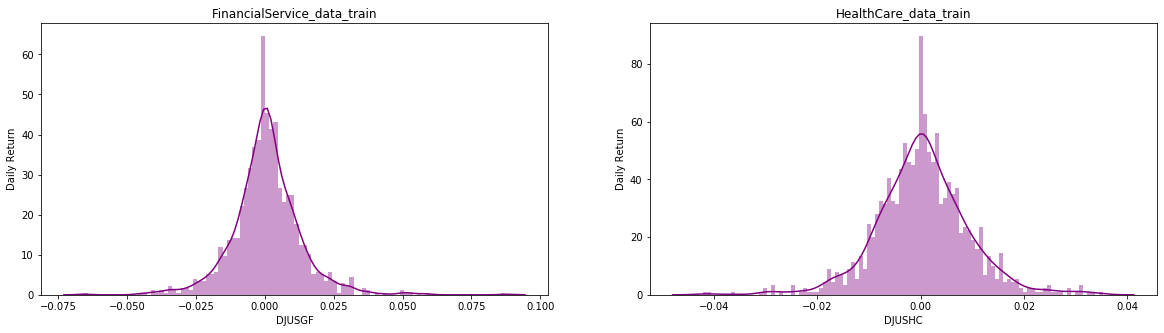

In [18]:
# Daily return for two indices

plt.figure(figsize=(20, 5))


for i, sector in enumerate(sectors, 1):
    plt.subplot(1, 2, i)
    sns.distplot((sector.pct_change()).dropna(), bins=100, color='purple')
    plt.ylabel('Daily Return')
    plt.title(f'{sectors_name[i - 1]}')




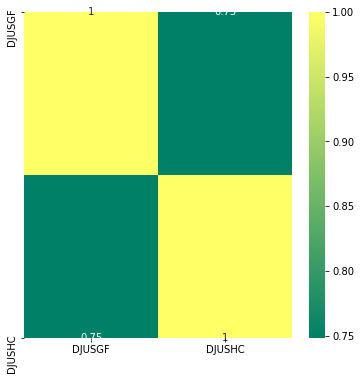

In [19]:
#Index price corrlation 
plt.figure(figsize=(6,6))
sns.heatmap(dataset.corr(), annot=True, cmap='summer')


Before applying any statistical model on a time series, we want to ensure it’s stationary
There are two primary way to determine whether a given time series is stationary:

1) Rolling Statistics: Plot the rolling mean and rolling standard deviation. 
   The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are     straight and parallel to the x-axis).
   
2) ADCF Test - Augmented Dickey–Fuller test: it is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a TS is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. THE ADCF test also gives us a p-value. Acc to the null hypothesis, lower values of p is better.






Text(0.5, 1.0, 'Rolling Mean & Standard Deviation for HealthCare train Index')

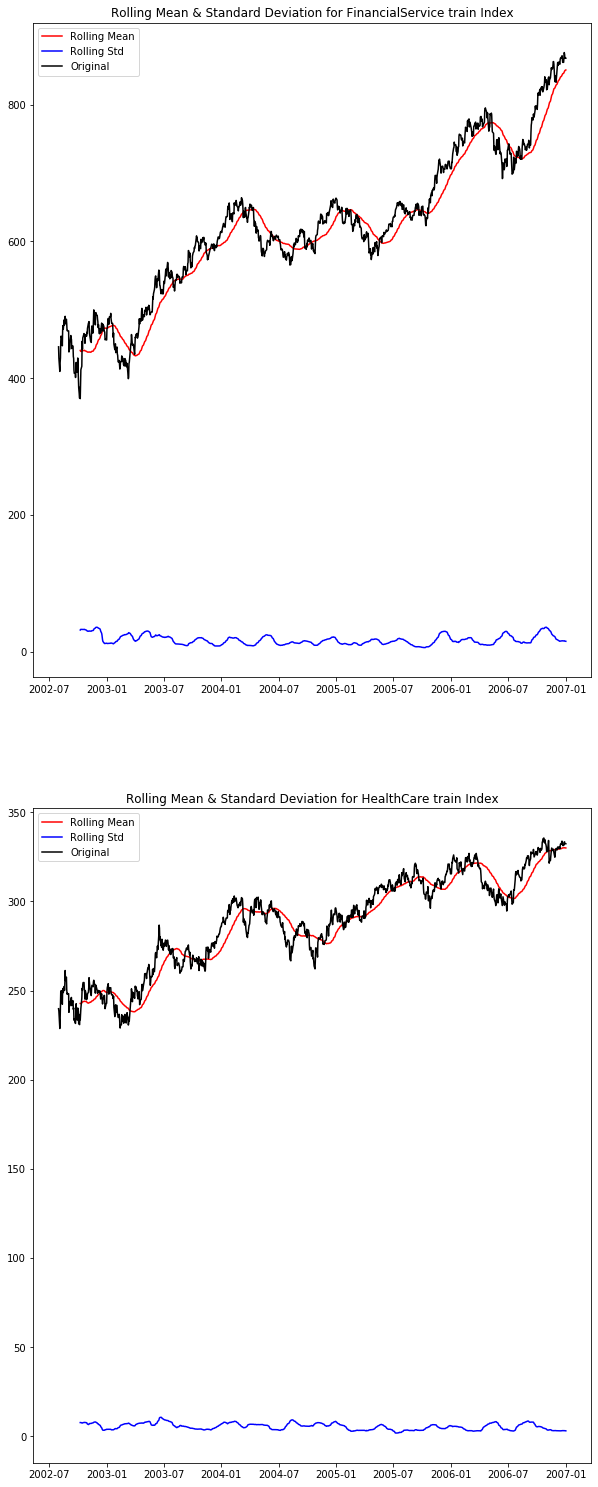

In [20]:
# Rolling Statistics

FS_rolling_mean=FinancialService_data_train.rolling(window = 50).mean()
FS_rolling_std=FinancialService_data_train.rolling(window = 50).std()

HC_rolling_mean=HealthCare_data_train.rolling(window = 50).mean()
HC_rolling_std=HealthCare_data_train.rolling(window = 50).std()
   

plt.figure(figsize=(10,400))
plt.subplots_adjust(top=1.25,bottom=1.2)


plt.subplot(2,1,1)
plt.plot(FS_rolling_mean, color='red', label='Rolling Mean') 
plt.plot(FS_rolling_std, color='blue',label='Rolling Std')
plt.plot(FinancialService_data_train, color='black', label='Original') 
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for FinancialService train Index') 

plt.subplot(2,1,2)
plt.plot(HC_rolling_mean, color='red', label='Rolling Mean') 
plt.plot(HC_rolling_std, color='blue',label='Rolling Std')
plt.plot(HealthCare_data_train, color='black', label='Original') 
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for HealthCare train Index') 




The rolling mean increase with time rolling but the standard deviation is fairly constant with time. Therefore, we can conclude that the time series is not stationary. Further test:


In [21]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
FS_result = adfuller(FinancialService_data_train)
HC_result = adfuller(HealthCare_data_train)

print("For Financial service sector:")
print('ADF Statistic: {}'.format(FS_result[0])) 
print('p-value: {}'.format(FS_result[1])) 

print("For Health Care sector:")
print('ADF Statistic: {}'.format(HC_result[0])) 
print('p-value: {}'.format(HC_result[1])) 




Results of Dickey Fuller Test:
For Financial service sector:
ADF Statistic: -0.5419395161429482
p-value: 0.8835692116767274
For Health Care sector:
ADF Statistic: -1.5588363786264186
p-value: 0.5042314055562857


the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

In [22]:
#Create a function to test stationary:
def test_stationarity(data,name):
  # rolling statistics
    rolling_mean = data.rolling(window=50).mean() 
    rolling_std = data.rolling(window=50).std()
  # rolling statistics plot
    plt.plot(rolling_mean, color='red', label='Rolling Mean') 
    plt.plot(rolling_std, color='blue',label='Rolling Std')
    plt.plot(data, color='black', label='Original') 
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {name}')
  # Dickey–Fuller test:
    result = adfuller(data)
    print(f"For {name} : ")
    print('ADF Statistic: {}'.format(result[0])) 
    print('p-value: {}'.format(result[1])) 


#Data Transformation to achieve Stationarity (Two ways)

In [23]:
#1 Log Scale Transformation

def log_scale_trans (data,i,name):   
    data_log = np.log(data) 
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(data_log)
    plt.title( f"{name} log ")
    rolling_mean = data_log.rolling(window=50).mean() 
    data_log_minus_mean = data_log - rolling_mean 
    data_log_minus_mean.dropna(inplace=True)
    plt.subplot(1,3,2)
    plt.plot(data_log_minus_mean)
    plt.title(f"{name}log minus mean")
    plt.subplot(1,3,3)
    test_stationarity(data_log_minus_mean,name)

For FinancialService_data_train : 
ADF Statistic: -5.832292543635261
p-value: 3.949314029297061e-07
For HealthCare_data_train : 
ADF Statistic: -4.808288032275597
p-value: 5.243487498851669e-05


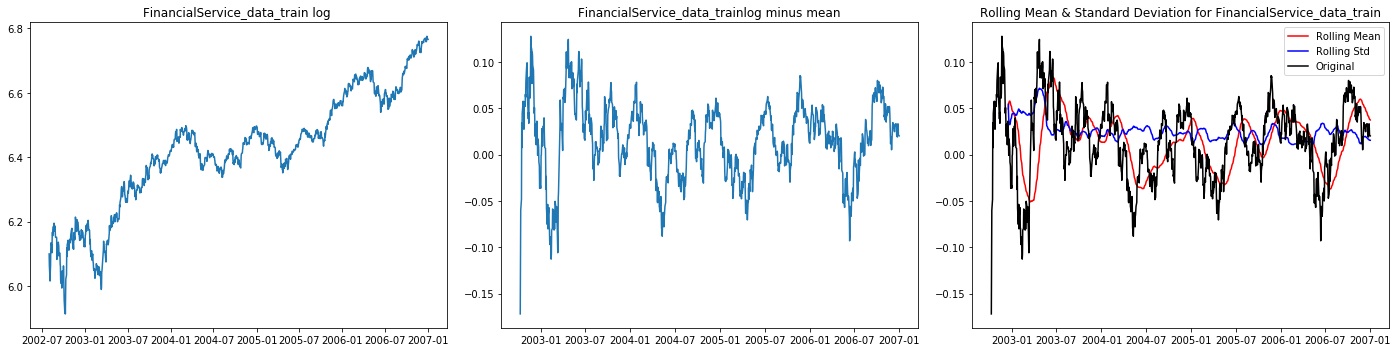

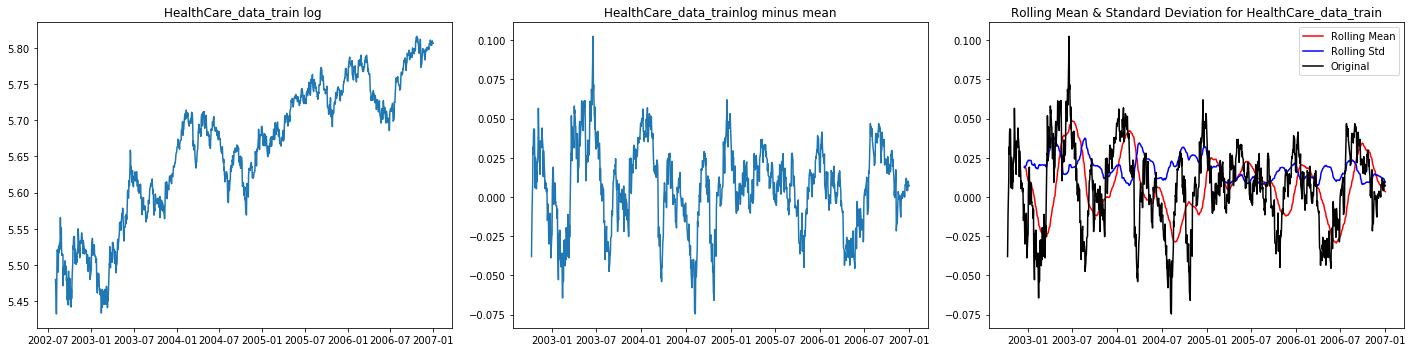

In [24]:
for i,sector in enumerate(sectors,1):
   
    log_scale_trans(sector,i,sectors_name[i-1])
    plt.tight_layout()

From the charts above, p-values are small than 0.05,Therefore, we have suffcient evidence to say the time series is stationary.

For FinancialService_data_train : 
ADF Statistic: -35.45468897586387
p-value: 0.0


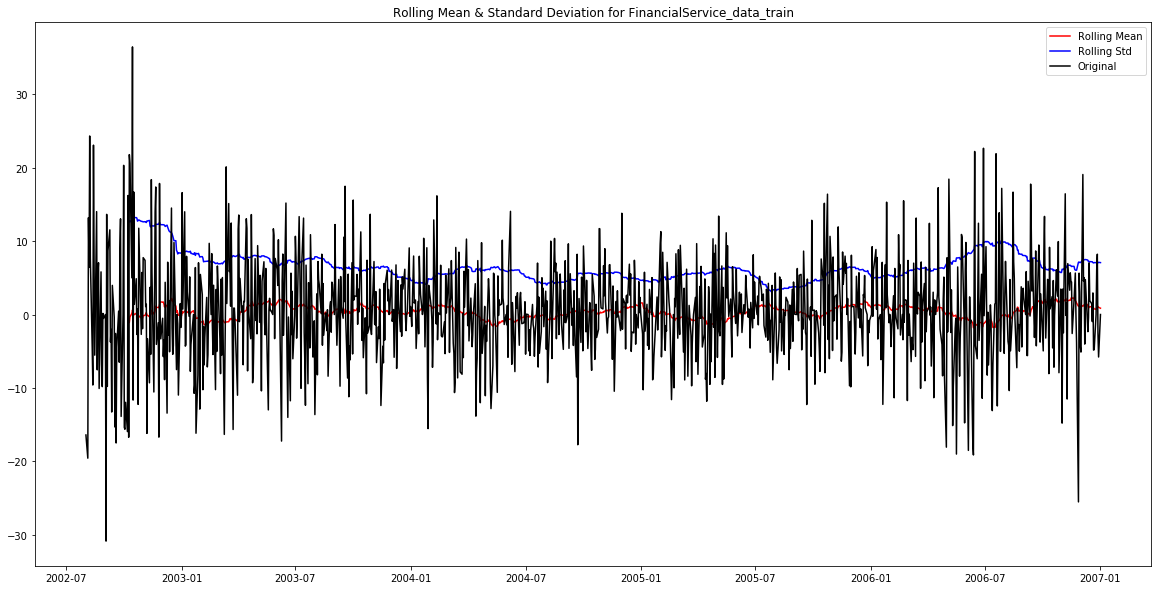

In [25]:
#2 Time Shift Transformation


FS_shift = FinancialService_data_train - FinancialService_data_train.shift() 
FS_shift.dropna(inplace=True)
plt.figure(figsize=(20,10))
test_stationarity(FS_shift,sectors_name[0])





For HealthCare_data_train : 
ADF Statistic: -22.332413930406936
p-value: 0.0


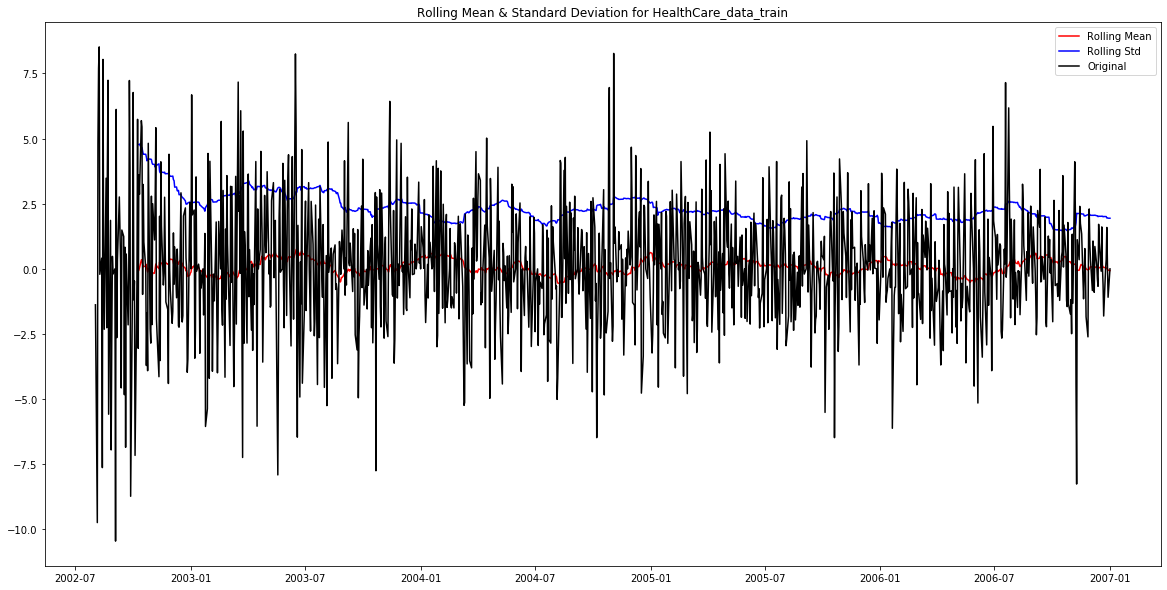

In [26]:

HC_shift = HealthCare_data_train - HealthCare_data_train.shift() 
HC_shift.dropna(inplace=True)
plt.figure(figsize=(20,10))
test_stationarity(HC_shift,sectors_name[1])



From the charts and p-value obtained above, we have suffcient evidence to say the time series is stationary.

AutoRegressive Integrated Moving Average Model (ARIMA)

Three integers (p, d, q) are typically used to parametrize ARIMA models.
p: number of autoregressive terms (AR order)
d: number of nonseasonal differences (differencing order) 
q: number of moving-average terms (MA order)

In [37]:
#Determine P
#Auto Correlation Function (ACF)
#The correlation between the observations at the current point in time and the observations at all previous points in time. 
#We can use ACF to determine the optimal number of MA terms. 


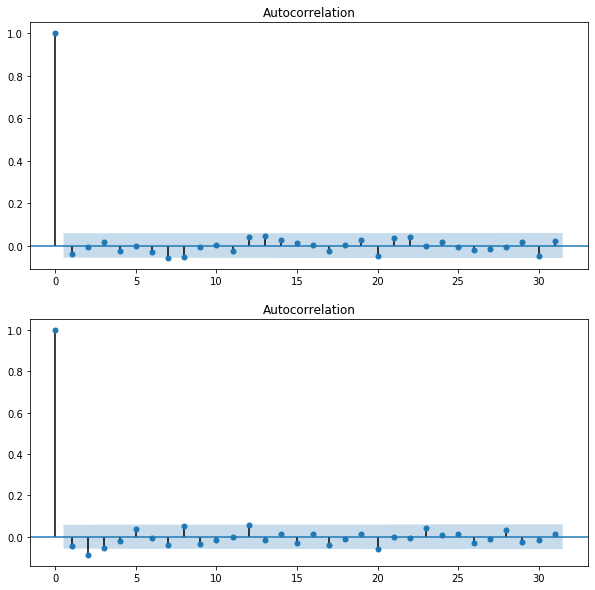

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#Plot ACF:


plt.figure(figsize=(10,10))
plt.subplot(211)
#Financial Service data
plot_acf(FS_shift, ax=plt.gca())
plt.subplot(212)
#Health Care data
plot_acf(HC_shift, ax=plt.gca())
plt.show()



From the charts above,
we choose p=8 for financial Service data
choose p=8 for Health Care data


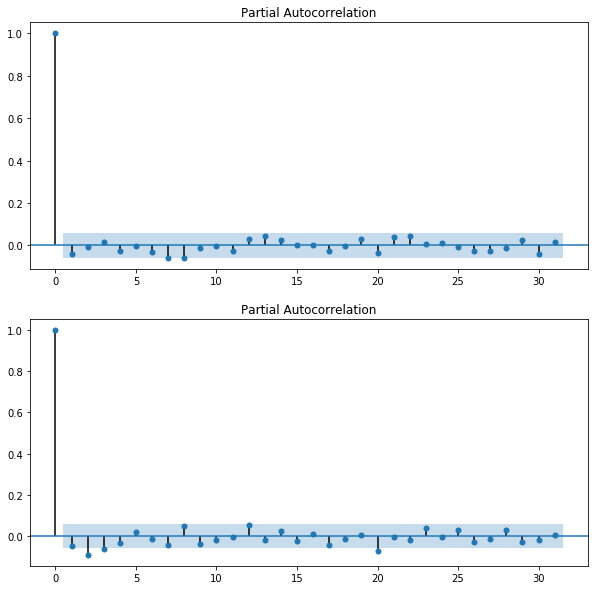

In [28]:
#Determie q
#Partial Auto Correlation Function (PACF)
#As the name implies, PACF is a subset of ACF. 
#PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. 
#We can use PACF to determine the optimal number of terms to use in the AR model.

#Plot PACF:


plt.figure(figsize=(10,10))
plt.subplot(211)
#Financial Service data
plot_pacf(FS_shift, ax=plt.gca())
plt.subplot(212)
#Health Care data
plot_pacf(HC_shift, ax=plt.gca())
plt.show()








From the charts above,
we choose q=8 for financial Service data
choose q=3 for Health Care data


In [29]:
#For Financial Service index data



# Build an ARIMA model with AR of order 8, differencing of order 1 and MA of order 8.
FS_model = ARIMA(FinancialService_data_train, order=(8,1,8))
fitted_FS = FS_model.fit(disp=-1)


/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
print(fitted_FS.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3656      0.194      1.889      0.059      -0.014       0.745
ar.L1.D.DJUSGF     0.4581   6.78e-05   6759.962      0.000       0.458       0.458
ar.L2.D.DJUSGF     0.1899      0.001    239.671      0.000       0.188       0.191
ar.L3.D.DJUSGF     0.3282      0.002    214.590      0.000       0.325       0.331
ar.L4.D.DJUSGF    -0.6151        nan        nan        nan         nan         nan
ar.L5.D.DJUSGF     0.2878      0.001    263.020      0.000       0.286       0.290
ar.L6.D.DJUSGF     0.1601      0.001    278.312      0.000       0.159       0.161
ar.L7.D.DJUSGF     0.4792        nan        nan        nan         nan         nan
ar.L8.D.DJUSGF    -0.9692        nan        nan        nan         nan         nan
ma.L1.D.DJUSGF    -0.4655      0.011    -42.889      0.000      -0.487      -0.444
ma.L

/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [31]:
#For Health Care index data



# Build an ARIMA model with AR of order 8, differencing of order 1 and MA of order 3.
HC_model = ARIMA(HealthCare_data_train, order=(8,1,3))
fitted_HC = HC_model.fit(disp=-1)


/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [38]:
print(fitted_HC.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0813      0.058      1.399      0.162      -0.033       0.195
ar.L1.D.DJUSHC    -1.1111      0.310     -3.582      0.000      -1.719      -0.503
ar.L2.D.DJUSHC    -1.0967      0.257     -4.263      0.000      -1.601      -0.592
ar.L3.D.DJUSHC    -0.8274      0.196     -4.216      0.000      -1.212      -0.443
ar.L4.D.DJUSHC    -0.2221      0.074     -3.010      0.003      -0.367      -0.077
ar.L5.D.DJUSHC    -0.1281      0.068     -1.874      0.061      -0.262       0.006
ar.L6.D.DJUSHC    -0.0486      0.057     -0.851      0.395      -0.160       0.063
ar.L7.D.DJUSHC    -0.0384      0.054     -0.711      0.477      -0.144       0.067
ar.L8.D.DJUSHC     0.0359      0.051      0.699      0.485      -0.065       0.136
ma.L1.D.DJUSHC     1.0587      0.309      3.424      0.001       0.453       1.665
ma.L

Use period 2007-01-02 to 2007-08-01 testing the accuracy 

In [32]:
#Obtain test set (actual stock price)
FS_test=dataset.loc["2007-01-02":"2007-08-01","DJUSGF"]
HC_test=dataset.loc["2007-01-02":"2007-08-01",'DJUSHC']


In [34]:
FS_test.describe()

count    152.000000
mean     875.728750
std       32.649747
min      799.710000
25%      845.885000
50%      884.695000
75%      899.560000
max      924.100000
Name: DJUSGF, dtype: float64

In [35]:
HC_test.describe()

count    152.000000
mean     347.131908
std       10.144379
min      327.540000
25%      339.365000
50%      345.140000
75%      356.102500
max      363.630000
Name: DJUSHC, dtype: float64

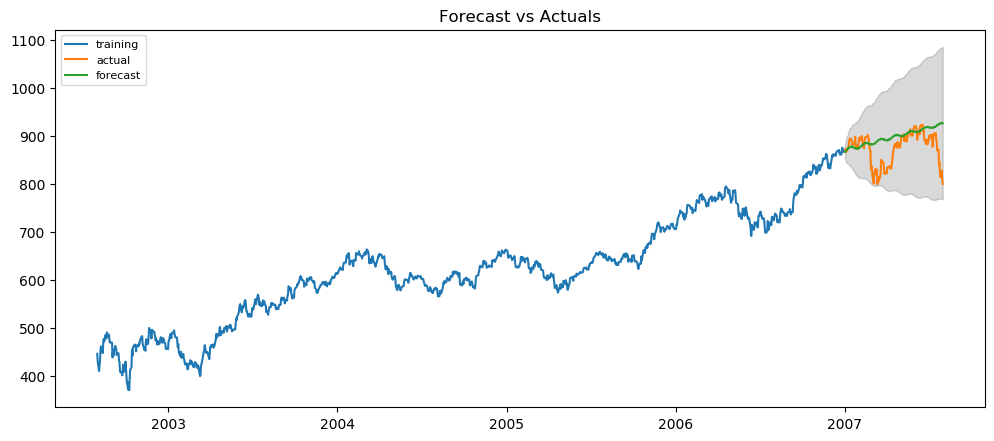

In [39]:
# FOR Financial Serivices Sector:


# Forecast 
FS_fc, FS_se, FS_conf = fitted_FS.forecast(152, alpha=0.05)  # 95% confidence interval




# Make as pandas series
FS_fc_series = pd.Series(FS_fc, index=FS_test.index)
FS_lower_series = pd.Series(FS_conf[:, 0], index=FS_test.index)
FS_upper_series = pd.Series(FS_conf[:, 1], index=FS_test.index)



# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(FinancialService_data_train, label='training')
plt.plot(FS_test, label='actual')
plt.plot(FS_fc_series, label='forecast')
plt.fill_between(FS_lower_series.index, FS_lower_series, FS_upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
            

In [44]:
pip install RegscorePy


Note: you may need to restart the kernel to use updated packages.


In [49]:
# Calculate AIC for the predicted data and actual data  
from RegscorePy import *
aic.aic(FS_fc_series, FS_test, 17)

1158.0098685388816

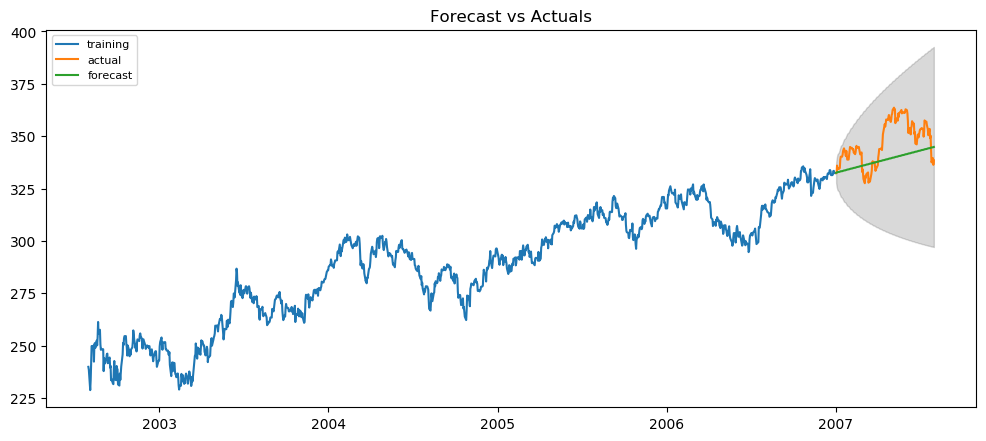

In [47]:
# Forecast
HC_fc, HC_se, HC_conf = fitted_HC.forecast(152, alpha=0.05)  # 95% confidence interval




# Make as pandas series
HC_fc_series = pd.Series(HC_fc, index=HC_test.index)
HC_lower_series = pd.Series(HC_conf[:, 0], index=HC_test.index)
HC_upper_series = pd.Series(HC_conf[:, 1], index=HC_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(HealthCare_data_train, label='training')
plt.plot(HC_test, label='actual')
plt.plot(HC_fc_series, label='forecast')
plt.fill_between(HC_lower_series.index, HC_lower_series, HC_upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
            

In [50]:
# Calculate AIC for the predicted data and actual data

aic.aic(HC_fc_series, HC_test, 12)

778.2999804322014